In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, chirp2total, total2chirp, overlap_cplx_wfs, get_h

In [2]:
sample_rate = 4096

# e^2 against chirp mass plots

In [3]:
# Calculates matches to a fiducial waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match(e_vals, chirp_vals, fiducials, f_low, fid_wf, approximant='TEOBResumS'):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'h1':[], 'h2':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Generate fiducial waveform
    if fid_wf == 'get_h':
        _, h1, h2, _, _ = get_h([1,1], f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant)
    elif fid_wf == 'TEOB':
        h = gen_wf(f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant)
    else:
        raise Exception('fid_wf not recognised')

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['h1'].append([])
        matches['h2'].append([])
        matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:
            
            # Create waveform at this grid point
            _, s1, s2, _, _ = get_h([1,1], f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)

            # Calculate matches
            if fid_wf == 'get_h':
                match_h1 = abs(overlap_cplx_wfs(h1, s1, f_low))
                match_h2 = abs(overlap_cplx_wfs(h2, s2, f_low))
            elif fid_wf == 'TEOB':
                match_h1 = abs(overlap_cplx_wfs(h, s1, f_low))
                match_h2 = abs(overlap_cplx_wfs(h, s2, f_low))
            match_quad = np.sqrt(match_h1**2+match_h2**2)
            matches['quad'][-1].append(match_quad)
            matches['h1'][-1].append(match_h1)
            matches['h2'][-1].append(match_h2)

            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [4]:
# Calculates matches to a fiducial h1, h2 waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match_inv(e_vals, chirp_vals, fiducials, f_low, approximant='TEOBResumS'):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'h1':[], 'h2':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Generate fiducial waveform
    _, h1, h2, _, _ = get_h([1,1], f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant)

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['h1'].append([])
        matches['h2'].append([])
        matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:
            
            # Create waveform at this grid point
            s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)

            # Calculate matches
            match_h1 = abs(overlap_cplx_wfs(h1, s, f_low))
            match_h2 = abs(overlap_cplx_wfs(h2, s, f_low))
            match_quad = np.sqrt(match_h1**2+match_h2**2)
            matches['quad'][-1].append(match_quad)
            matches['h1'][-1].append(match_h1)
            matches['h2'][-1].append(match_h2)

            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [5]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot(e_vals, chirp_vals, fiducials, matches, vmins=None, vmaxs=None):

    # Default vmins and vmaxs value depends on number of plots
    if vmins == None:
        vmins = [0.7]*len(matches.keys())
    if vmaxs == None:
        vmaxs = [1]*len(matches.keys())
    
    # Convert to eccentricity squared
    e2_vals = e_vals**2

    # Make contour plot for each match
    for i, key in enumerate(matches.keys()):
        plt.contourf(chirp_vals, e2_vals, matches[key], np.linspace(vmins[i], vmaxs[i], 15), vmin=vmins[i], vmax=vmaxs[i], extend='min')
        plt.colorbar(label='match')
        plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

# $e_{10}=0.1, \mathcal{M}=24~M_\odot, q=2$

Matching h1 against fiducial h1, h2 against fiducial h2

In [6]:
e_vals_1 = np.linspace(0, 0.2, 11)
chirp_vals_1 = np.linspace(23, 25, 11)
start = time.time()
dataslot_1 = ecc_chirp_match(e_vals_1, chirp_vals_1, [0.1, 24, 2], 10, 'get_h')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

121 done out of 121
Time taken: 556.4682188034058 seconds


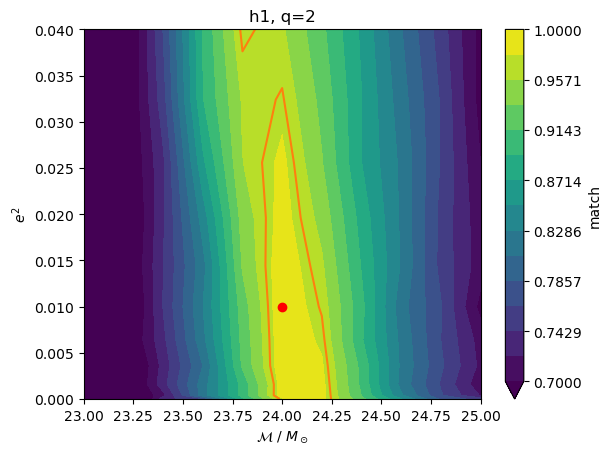

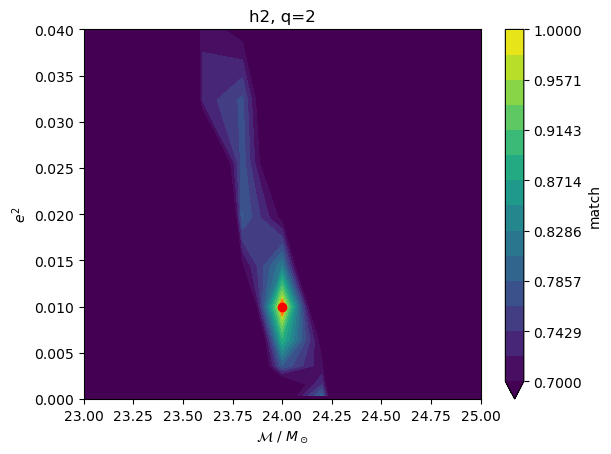

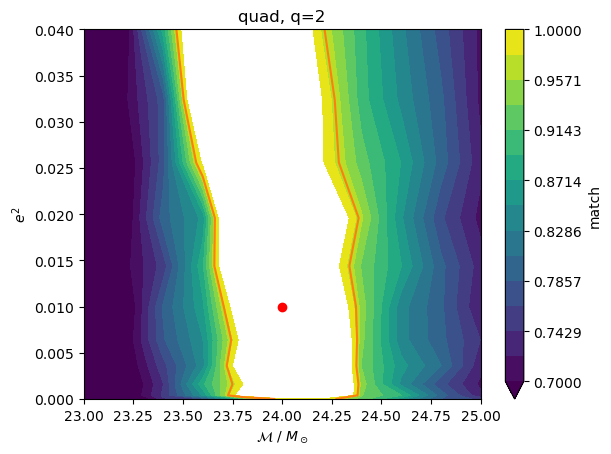

In [7]:
ecc_chirp_plot(e_vals_1, chirp_vals_1, [0.1, 24, 2], dataslot_1)

Matching h1 against fiducial (TEOB) h, h2 against fiducial (TEOB) h

In [8]:
e_vals_2 = e_vals_1
chirp_vals_2 = chirp_vals_1
start = time.time()
dataslot_2 = ecc_chirp_match(e_vals_2, chirp_vals_2, [0.1, 24, 2], 10, 'TEOB')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

121 done out of 121
Time taken: 553.2921845912933 seconds


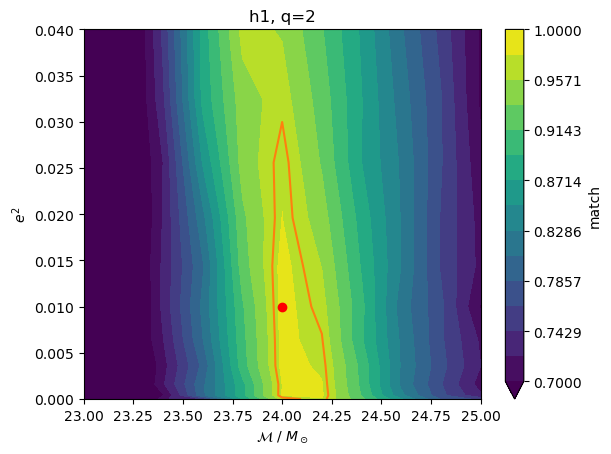

/local/ben.patterson/ipykernel_197635/3420723985.py:17: UserWarning: No contour levels were found within the data range.
  plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])


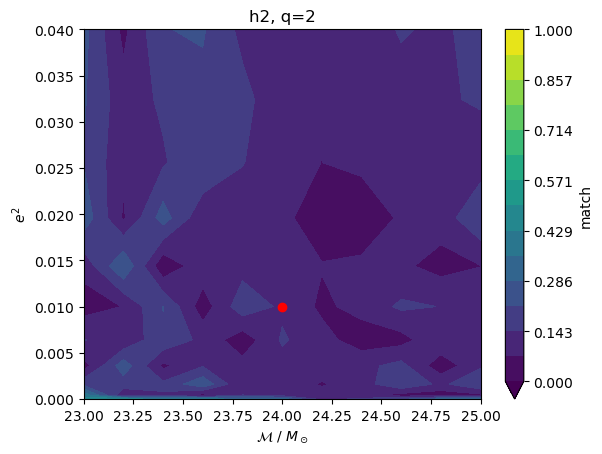

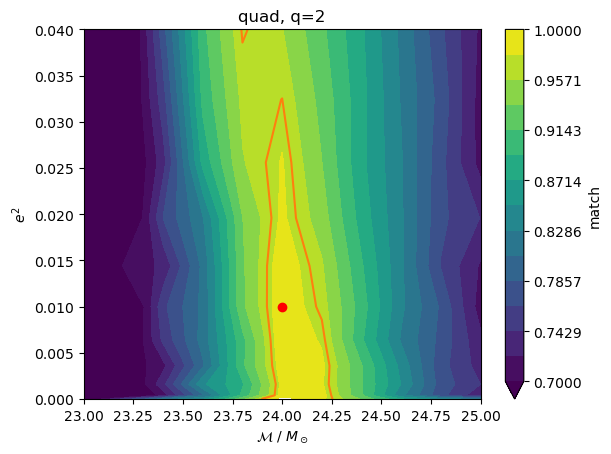

In [9]:
ecc_chirp_plot(e_vals_2, chirp_vals_2, [0.1, 24, 2], dataslot_2, vmins=[0.7,0,0.7])

Matching (TEOB) h against fiducial h1, h2

In [10]:
e_vals_3 = e_vals_1
chirp_vals_3 = chirp_vals_1
start = time.time()
dataslot_3 = ecc_chirp_match_inv(e_vals_3, chirp_vals_3, [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

121 done out of 121
Time taken: 216.79542207717896 seconds


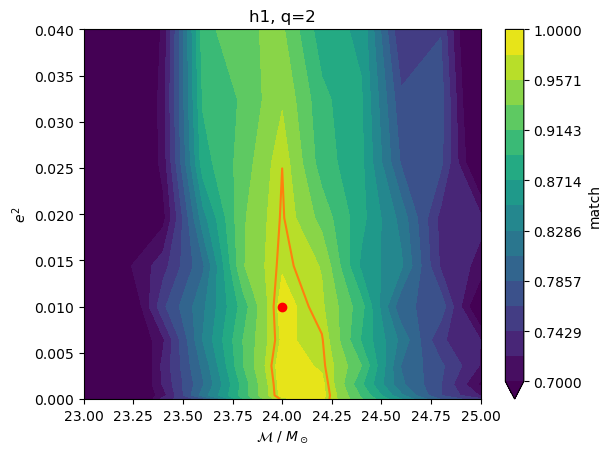

/local/ben.patterson/ipykernel_197635/3420723985.py:17: UserWarning: No contour levels were found within the data range.
  plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])


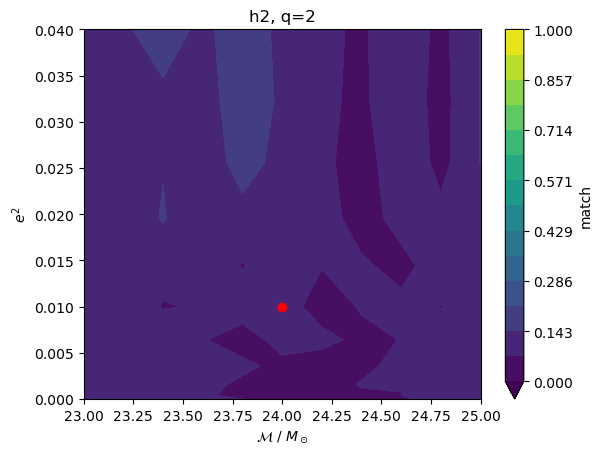

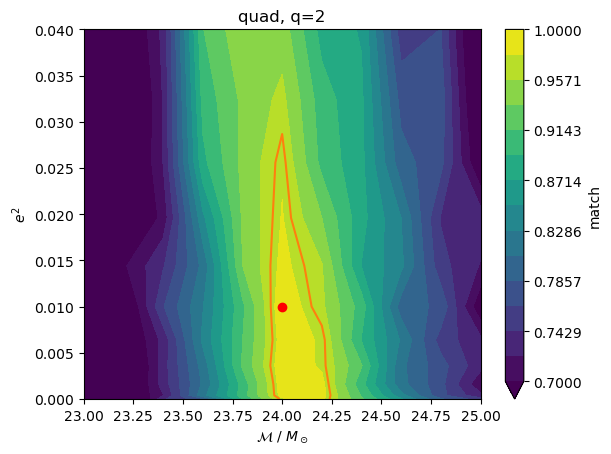

In [11]:
ecc_chirp_plot(e_vals_3, chirp_vals_3, [0.1, 24, 2], dataslot_3, vmins=[0.7,0,0.7])

# $e_{20}=0.1, M=30~(\mathcal{M}=12.167)~M_\odot, q=2$

Matching h1 against fiducial h1, h2 against fiducial h2

In [12]:
e_vals_4 = np.linspace(0, 0.2, 11)
chirp_vals_4 = np.linspace(*total2chirp(np.array([29,31]),2), 11)
start = time.time()
dataslot_4 = ecc_chirp_match(e_vals_4, chirp_vals_4, [0.1, total2chirp(30,2), 2], 20, 'get_h')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

121 done out of 121
Time taken: 491.1615834236145 seconds


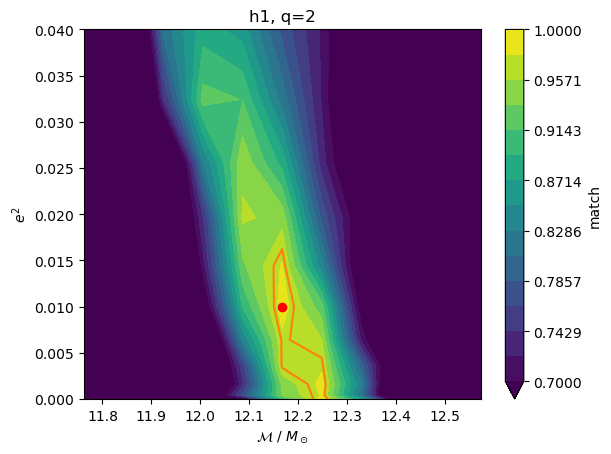

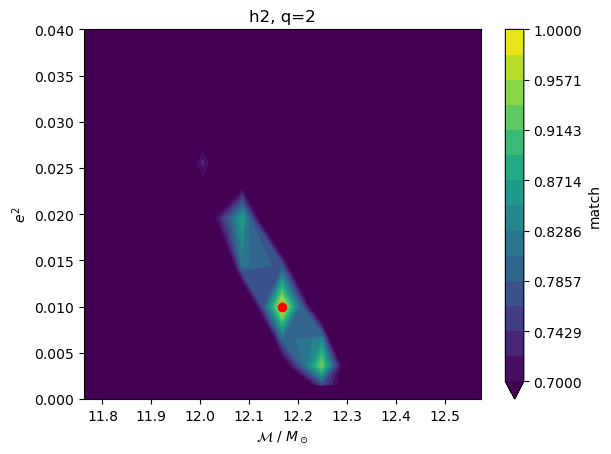

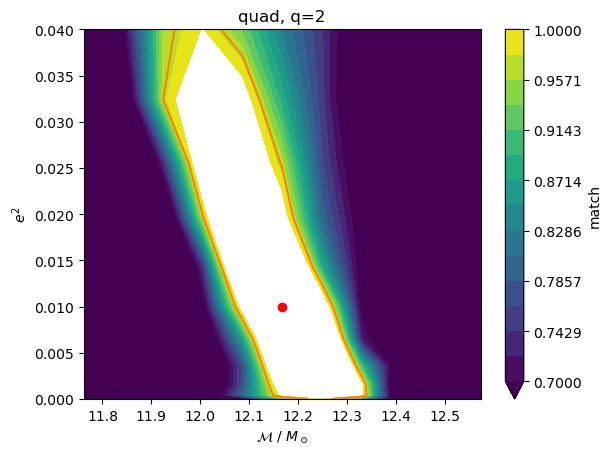

In [13]:
ecc_chirp_plot(e_vals_4, chirp_vals_4, [0.1, total2chirp(30,2), 2], dataslot_4, vmins=[0.7,0.7,0.7])

Matching h1 against fiducial (TEOB) h, h2 against fiducial (TEOB) h

In [14]:
e_vals_5 = e_vals_4
chirp_vals_5 = chirp_vals_4
start = time.time()
dataslot_5 = ecc_chirp_match(e_vals_5, chirp_vals_5, [0.1, total2chirp(30,2), 2], 20, 'TEOB')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

121 done out of 121
Time taken: 490.9884204864502 seconds


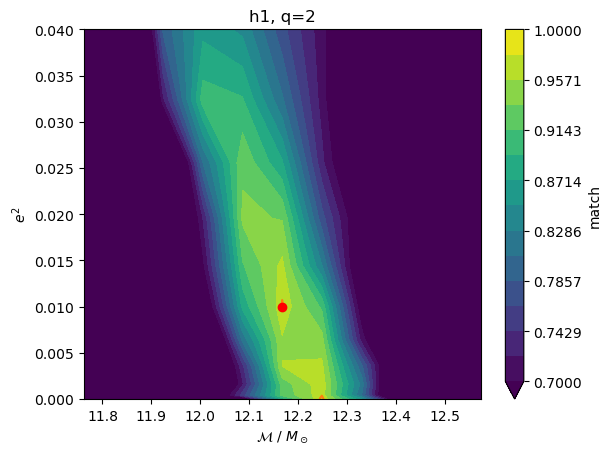

/local/ben.patterson/ipykernel_197635/3420723985.py:17: UserWarning: No contour levels were found within the data range.
  plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])


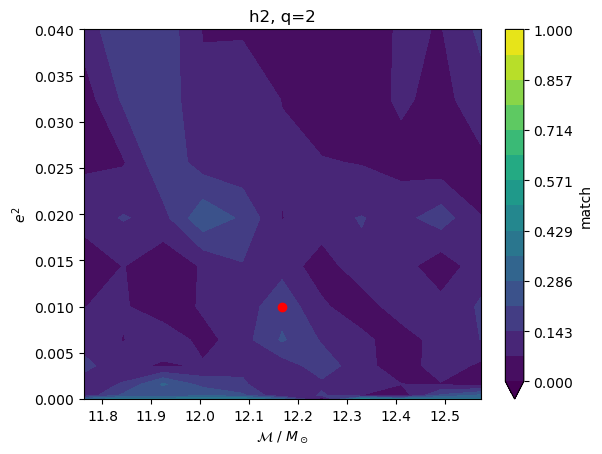

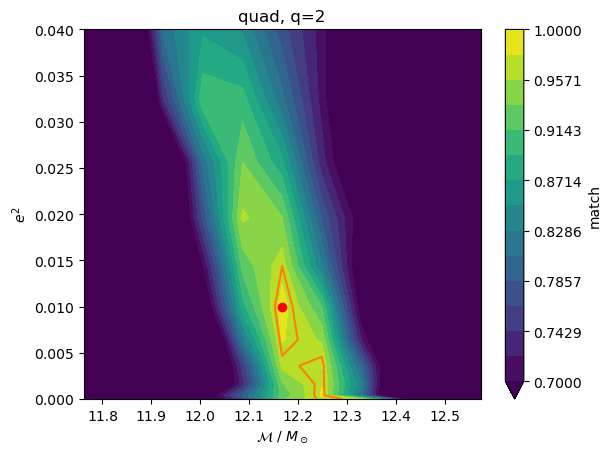

In [15]:
ecc_chirp_plot(e_vals_5, chirp_vals_5, [0.1, total2chirp(30,2), 2], dataslot_5, vmins=[0.7,0,0.7])

Matching (TEOB) h against fiducial h1, h2

In [16]:
e_vals_6 = e_vals_4
chirp_vals_6 = chirp_vals_4
start = time.time()
dataslot_6 = ecc_chirp_match_inv(e_vals_6, chirp_vals_6, [0.1, total2chirp(30,2), 2], 20,)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

121 done out of 121
Time taken: 181.61253142356873 seconds


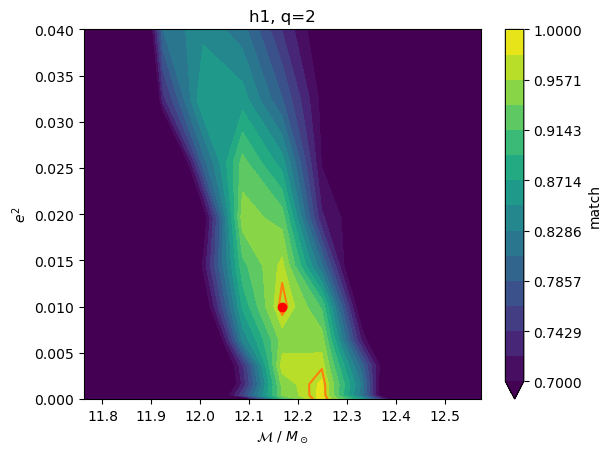

/local/ben.patterson/ipykernel_197635/3420723985.py:17: UserWarning: No contour levels were found within the data range.
  plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])


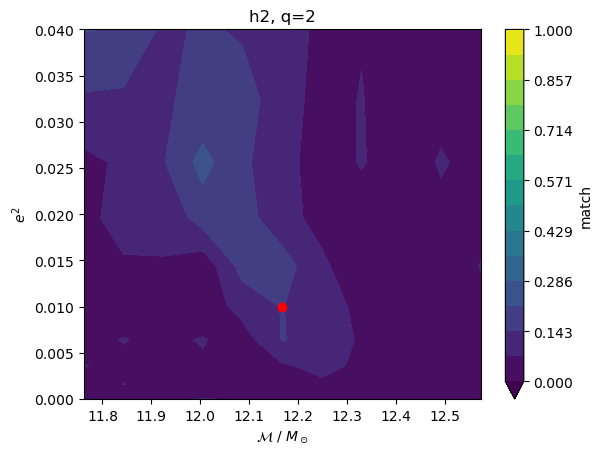

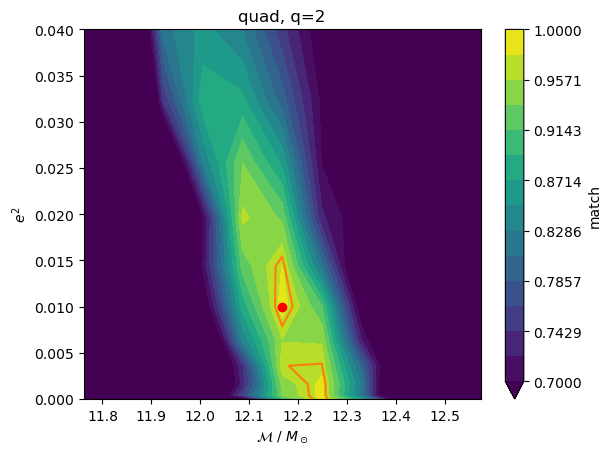

In [17]:
ecc_chirp_plot(e_vals_6, chirp_vals_6, [0.1, total2chirp(30,2), 2], dataslot_6, vmins=[0.7,0,0.7])